Study example following the medium post by Susan Li

url: https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


AttributeError: module 'tensorflow.python.saved_model.signature_constants' has no attribute 'DEFAULT_TRAIN_SIGNATURE_DEF_KEY'

In [3]:
data = pd.read_csv('household-electric-power-consumption.zip', 
                   header=0, sep=';', 
                   infer_datetime_format=True,
                   parse_dates = {'datetime':[0,1]},
                   index_col=['datetime'],
                   compression='zip')
print(data.shape)
data.head()

(2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [12]:
#summary of column data types
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [13]:
#summary of missing values
data.isnull().sum()/len(data)

Global_active_power     0.0000
Global_reactive_power   0.0000
Voltage                 0.0000
Global_intensity        0.0000
Sub_metering_1          0.0000
Sub_metering_2          0.0000
Sub_metering_3          0.0125
dtype: float64

Strategy:
1. Interested in global active power column. Drop remining.
2. Convert ? to nan and drop to clean
3. Drop Nans and convert golbal active power to float
4. Create year, quarter, month, and day feautres
5. Create a weekday and weekend features with values 0, 1.

In [18]:
data = data.drop(columns=['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'])

In [6]:
data.isnull().sum()/len(data)

Global_active_power     0.0000
Global_reactive_power   0.0000
Voltage                 0.0000
Global_intensity        0.0000
dtype: float64

In [15]:
cols_to_float = ['Global_active_power', 'Global_reactive_power', 'Voltage'
                , 'Global_intensity']
data[cols_to_float] = data[cols_to_float].replace('?', np.nan)
data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [16]:
data = data.dropna()

In [17]:

data[cols_to_float] = data[cols_to_float].astype(float)

In [12]:
#export data
data.to_csv('home-power-consumption-clean.csv')

In [21]:
data['year'] = data.index.year
data['quarter'] = data.index.quarter
data['month'] = data.index.month
data['day'] = data.index.day

In [22]:
data['weekday_num'] = data.index.weekday

In [23]:
data['weekday'] = data['weekday'] >5

KeyError: 'weekday'

In [119]:
data['weekend'] = data['weekday'].replace({True: 1, False: 0})

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
year                     int64
quarter                  int64
month                    int64
day                      int64
weekend                  int64
dtypes: float64(4), int64(5)
memory usage: 156.3 MB


In [25]:
#rename columns for easy access
data.columns = ['total_power', 'reactive_power', 'voltage',
       'current', 'year', 'quarter', 'month', 'day', 'weekend']

##### Data Normality and Visualization

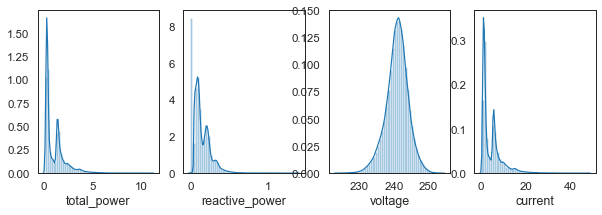

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(10,3))
features = ['total_power', 'reactive_power', 'voltage',
       'current']

for ax, feature in zip(axs,features):
    sns.distplot(data[feature], ax=ax)
plt.show()

Of the main numerical features only voltage is close to a normal distribution. The remining features are heaivly left skewed.

Plot a typical day sice for each feature.

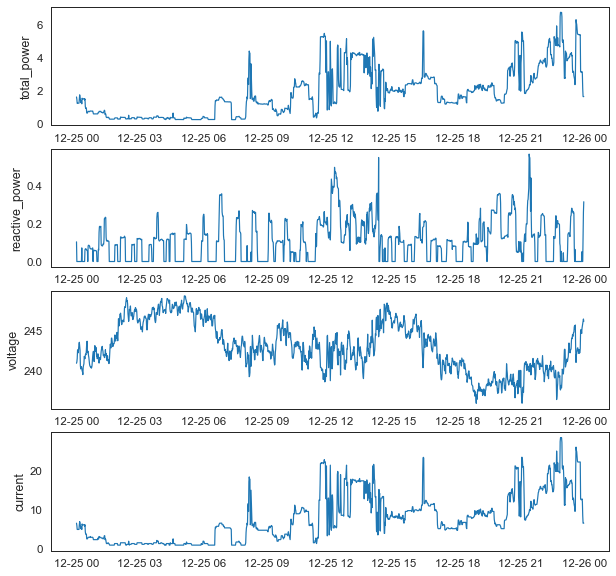

In [27]:
day_slice = data['2007-12-25']

fig, axs = plt.subplots(4, 1, figsize=(10,10))

for ax, feature in zip(axs,features):
    ax.plot(day_slice[feature])
    ax.set_ylabel(feature)
plt.show()

How are each of these correlated?

In [332]:
correlations = data[['total_power', 'reactive_power', 'voltage','current']].corr()
correlations


,total_power,reactive_power,voltage,current
total_power,1.0000,0.2470,-0.3998,0.9989
reactive_power,0.2470,1.0000,-0.1122,0.2661
voltage,-0.3998,-0.1122,1.0000,-0.4114
current,0.9989,0.2661,-0.4114,1.0000


KeyError: <matplotlib.axes._subplots.AxesSubplot object at 0x1c79199a20>

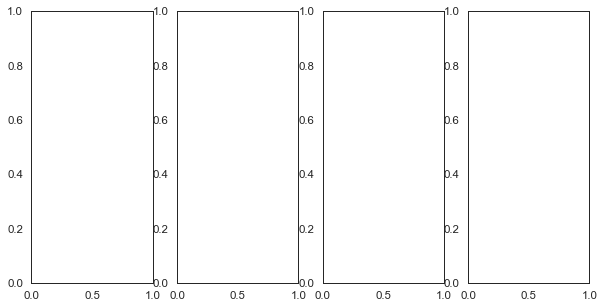

In [331]:
fig, axs = plt.subplots(1,4,figsize=(10,5))


Compare the total_power consumption between a random weekday and a wekend or holiday (i.e. christmas). Builds the case for a holiday feature vector as well.

How was power conusmption changed through the years 2006-2010?

How did power consumption change on a quarterly baiss?

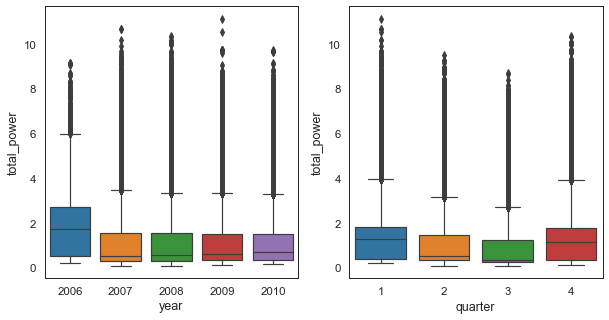

In [110]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

sns.boxplot(x='year', y='total_power', data=data, ax=axs[0])
sns.boxplot(x='quarter', y='total_power', data=data, ax=axs[1])

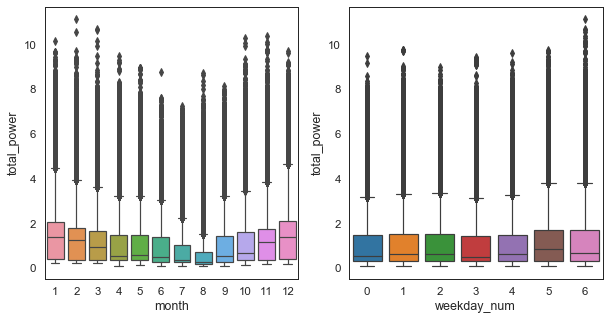

In [120]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

sns.boxplot(x='month', y='total_power', data=data, ax=axs[0])
sns.boxplot(x='weekday_num', y='total_power', data=data, ax=axs[1])

## Additional Exploratory Anlysis

Namely:

 - unit root test for stationary
 - mean consumption by day, month, quarter, year
 - mean consumption weekend vs weekday

## LSTM Model - Single Variable


In [28]:
#create a dataset for training/testing

power_30m = data['total_power'].resample('T').max()

In [261]:
data['total_power'].shape

(2049280,)

In [263]:
power_30m.head()

datetime
2006-12-16 17:00:00   5.3880
2006-12-16 17:30:00   7.7060
2006-12-16 18:00:00   6.7520
2006-12-16 18:30:00   6.0720
2006-12-16 19:00:00   4.0700
Freq: 30T, Name: total_power, dtype: float64

##### Create single variable test/train sets

In [29]:
#this code is copied from the original source in order to understand it.
dataset = data['total_power'].values #numpy.ndarray
dataset = dataset.astype('float32')

dataset = np.reshape(dataset, (-1, 1))

#scales the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#splits the data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [30]:
#this function copied from the original source for understanding.
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    #range(100 - 3-1 )= 96 0-95 vals
    for i in range(len(dataset)-look_back-1):
        # i=0 win = 4
        window_len = i+ look_back
        #a slice of numbers from 0 to 4
        a = dataset[i:window_len, 0]
        #append slice to X
        X.append(a)
        # append single value from data 4 i.e. the next value in sequence
        Y.append(dataset[i + look_back, 0])
    
    return np.array(X), np.array(Y)

In [266]:
train.shape, test.shape

((55341, 1), (13836, 1))

In [182]:
train[4]

array([0.4555972], dtype=float32)

Ok the above function makes columns for time shifts. So a lookback of 1 returns just one column. lookback of two returns t and t-1 shifted column.

It takes in a numpy series of values.

This means the vector being fed to the LSTM model is:
X: t-1, t-2, t-3, ..., t-lookback
Y: t

or as expressed in the article
X: t, t-1, ... t-30
Y: t+1

It is a Walk Forward Model!


SO each column in X is a training example

Comments:
Uses a for loop and is not vectorized. Using hourly data so not bad. Is there a way to vecotrise using pandas.shift function?



In [31]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)

In [32]:
X_train.shape, X_test.shape

((1639393, 30), (409825, 30))

In [33]:
#reshapes the input to the format [samples, time_steps, features]

X_train = np.reshape(X_train, 
                     (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, 
                    (X_test.shape[0], 1, X_test.shape[1]))



reshaping makes the input data 3D volume. Why?

Axis breakdown
x is number of samples
y has unit dimensionality so carries no information
z is the features t, t-1, t-2 going back in time from the timestep x

so along x-y it is a long thin rectangle 30 units deep in z.

In [178]:
train[0:10]

array([[0.6368162 ],
       [0.5450449 ],
       [0.50900584],
       [0.48854968],
       [0.4555972 ],
       [0.32255456],
       [0.3010316 ],
       [0.27320087],
       [0.5011082 ],
       [0.22733769]], dtype=float32)

In [184]:
X_train[0:10]

array([[0.6368162 , 0.5450449 , 0.50900584],
       [0.5450449 , 0.50900584, 0.48854968],
       [0.50900584, 0.48854968, 0.4555972 ],
       [0.48854968, 0.4555972 , 0.32255456],
       [0.4555972 , 0.32255456, 0.3010316 ],
       [0.32255456, 0.3010316 , 0.27320087],
       [0.3010316 , 0.27320087, 0.5011082 ],
       [0.27320087, 0.5011082 , 0.22733769],
       [0.5011082 , 0.22733769, 0.23897955],
       [0.22733769, 0.23897955, 0.32498342]], dtype=float32)

In [185]:
Y_train[0:10]

array([0.48854968, 0.4555972 , 0.32255456, 0.3010316 , 0.27320087,
       0.5011082 , 0.22733769, 0.23897955, 0.32498342, 0.2909537 ],
      dtype=float32)

##### Test rig for model

How to turn this into a function type model?

In [34]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


W0809 14:44:31.962117 4504200640 deprecation_wrapper.py:119] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 14:44:32.008251 4504200640 deprecation_wrapper.py:119] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 14:44:32.012444 4504200640 deprecation_wrapper.py:119] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 14:44:32.289893 4504200640 deprecation_wrapper.py:119] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecate

Notes on testing:
- Changing the input to different samples gave exploding loss funciton.
    - try changing the learning rate under this condition
- Changed the batch size to a multiple of the z vector component. Improved performance.

In [35]:
start = time()
history = model.fit(X_train, Y_train,
                    epochs=3,
                    batch_size=90,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

stop = time()
print('Total training time {}'.format(stop-start))

W0809 14:44:36.990136 4504200640 deprecation.py:323] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0809 14:44:37.618497 4504200640 deprecation_wrapper.py:119] From /Users/ns/anaconda3/envs/ai-bootcamp/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1639393 samples, validate on 409825 samples
Epoch 1/3
 433260/1639393 [======>.......................] - ETA: 2:43 - loss: 0.0011

KeyboardInterrupt: 

A breakdown of what all these terms mean:

X, Y are the 
ephochs
batch_size
validation_data
callbacks
- early stopping
- monitor
- patience
verbose
shuffle


In [211]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


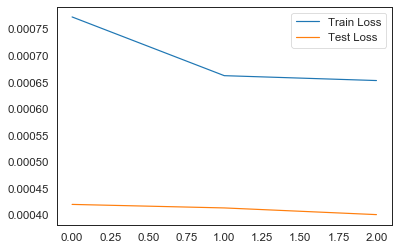

In [237]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

Why is test loss lower than train loss? This seems like overfitting...

##### Predictions

1563895277.4697092

In [231]:
start = time()
train_prediction = model.predict(X_train)
stop = time()
print('running time {}'.format(stop-start))

running time 97.0048439502716


In [232]:
start = time()
test_prediction = model.predict(X_test)
stop = time()
print('running time {}'.format(stop-start))

running time 23.8345730304718


Making a prediction on the training set takes several minutes.


In [234]:
train_prediction = scaler.inverse_transform(train_prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [235]:
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

In [238]:
test_prediction[0:10]

array([[0.26783764],
       [0.2638984 ],
       [0.27694842],
       [0.262366  ],
       [0.26613694],
       [0.26484337],
       [0.2805081 ],
       [0.27523932],
       [0.2504509 ],
       [0.29034293]], dtype=float32)

## LSTM Model - Two Variables


In [363]:
#this code is copied from the original source in order to understand it.
power = data['total_power'].values #numpy.ndarray
power = power.astype('float32')

reactive = data['reactive_power'].values
reactive = reactive.astype('float32')


power = np.reshape(power, (-1, 1))
reactive = np.reshape(reactive, (-1,1))


#creates a scalar object to transform the data bound by 0,1
scaler = MinMaxScaler(feature_range=(0, 1))

power = scaler.fit_transform(power)
reactive = scaler.fit_transform(reactive)

#sets the size of the train and the test
# should really use train / dev / test (have enough data)
train_size = int(len(power) * 0.80)
n_length = len(power)

dataset = [power, reactive]
dataset = np.array(dataset)

#train


train, test = dataset[:, 0:train_size,:], dataset[:, train_size:n_length,:]



In [365]:
train.shape, test.shape

((2, 1639424, 1), (2, 409856, 1))

train and test should be vectors of the shape
2, 2049280, 1.


In the next step want to reshape the vector to add 30 days past data.
So the new dimension will be
train: 2, 1639424, 30
test: 2, 409856, 30

In [395]:
#this function copied from the original source for understanding.
def create_vector(dataset, look_back=3):
    X, Y = [], []
    #range(100 - 3-1 )= 96 0-95 vals
    for i in range(len(dataset)-look_back-1):
        # i=0 win = 4
        window_len = i+ look_back
        #a slice of numbers from 0 to 4
        a = dataset[i:window_len, 0]
        #append slice to X
        X.append(a)
        # append single value from data 4 i.e. the next value in sequence
        Y.append(dataset[i + look_back, 0])
    
    return np.array(X), np.array(Y)

In [465]:
#this function copied from the original source for understanding.
def create_2d_vector(vector, look_back=3):
    
    X = []
    Y = []
    
    for j in range(0,vector.shape[0]):
        x, y = create_vector(vector[j,:], look_back)
        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y[1])

In [466]:
X_train, Y_train = create_2d_vector(train, 30)
X_test, Y_test = create_2d_vector(test, 30)

In [453]:
Y_test.shape

(409825,)

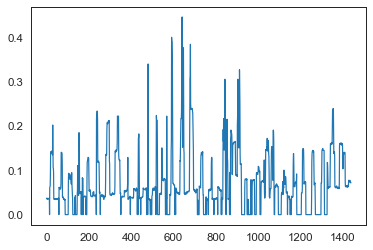

In [467]:
plt.plot(Y_test[:1440])

In [469]:
print('Training set dims X:{}, Y:{}'.format(X_train.shape, Y_train.shape))
print('Testing set dims X:{}, Y{}'.format(X_test.shape, Y_test.shape))

Training set dims X:(2, 1639393, 30), Y:(1639393,)
Testing set dims X:(2, 409825, 30), Y(409825,)


In [470]:
#reshape as abovein the single input version

X_train = np.reshape(X_train, (X_train.shape[1], 2, X_train.shape[2]))

X_test = np.reshape(X_test, (X_test.shape[1], 2, X_test.shape[2]))

##### Copy of the above model

In [437]:
model_2d = Sequential()
model_2d.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model_2d.add(Dropout(0.2))
model_2d.add(Dense(1))
model_2d.compile(loss='mean_squared_error', optimizer='adam')

In [471]:
start = time()
history = model_2d.fit(X_train, Y_train,
                    epochs=3,
                    batch_size=180,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
                    verbose=1,
                    shuffle=False)

stop = time()
print('Total training time {}'.format(stop-start))


Train on 1639393 samples, validate on 409825 samples
Epoch 1/3
1639393/1639393 [==============================] - 234s 143us/step - loss: 0.0063 - val_loss: 0.0070
Epoch 2/3
1639393/1639393 [==============================] - 237s 144us/step - loss: 0.0063 - val_loss: 0.0070
Epoch 3/3
1639393/1639393 [==============================] - 235s 143us/step - loss: 0.0063 - val_loss: 0.0070
Total training time 706.4490838050842


In [440]:
start = time()
train_predict = model_2d.predict(X_train)
stop = time()
print('running time {}'.format(stop-start))

running time 148.22163605690002


In [441]:
start = time()
test_predict = model_2d.predict(X_test)
stop = time()
print('running time {}'.format(stop-start))

running time 37.64955496788025


In [442]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

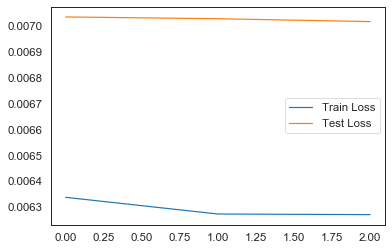

In [443]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

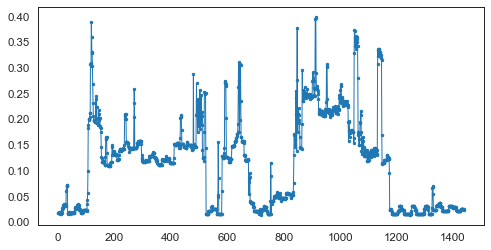

In [464]:
aa=[x for x in range(1440)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0:1440], marker='.', label="actual", linewidth=1)
#plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")